<a href="https://colab.research.google.com/github/kleeresearch/TextAnalysis/blob/master/Course/Day3/10__Kr_network_analysis_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 전처리 하기

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813256 sha256=745502d577baf379845a7b58c7089106f9c8a1351f9825e35ef38c1a2cfcdabb
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


In [6]:
from kiwipiepy import Kiwi
import re
from collections import Counter
kiwi = Kiwi()
from kiwipiepy.utils import Stopwords
stopwords = Stopwords()
customized_stopwords = ['연합뉴스', '네이버', '기자', '문의']
for word in customized_stopwords:
    stopwords.add((word, 'NNG'))

def do_Kr_preprocessing(text):
    cleaned_content = re.sub(r'[^\w\d\s]','',text) # To remove symbols
    cleaned_content = cleaned_content.lower() # Case conversion, upper -> lower
    word_tokens = kiwi.tokenize(cleaned_content, stopwords=stopwords)
    NN_words = []   # To select nouns
    for token in word_tokens:
        if 'NN' in token.tag:
            NN_words.append(token.form)
    final_NN_words = []
    for word in NN_words:
        if len(word) > 1:
            final_NN_words.append(word)

    return final_NN_words

In [7]:
# 네트워크 생성
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import networkx as nx
def construct_network(text):
    vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
    DTM_tf = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    DTM = np.array(DTM_tf.todense())
    DTM_binary = np.sign(DTM)
    words_cooccurrence = np.dot(DTM_binary.T, DTM_binary)
    np.fill_diagonal(words_cooccurrence, 0)
    #print(feature_names) # 네트워크를 구성하는 단어 출력하기
    #print(words_cooccurrence) # 단어들 간의 인접행렬 출력하기
    g = nx.convert_matrix.from_numpy_array(words_cooccurrence)
    mapping = {}
    for k, word in enumerate(feature_names):
        mapping[k]=word
    g1 = nx.relabel_nodes(g, mapping)
    return g1

def get_text_network(text, selected_words):
    cleaned_docs = [do_Kr_preprocessing(doc) for doc in text]
    new_docs=[]
    for doc in cleaned_docs:
        new_doc=[]
        for word in doc:
            if word in selected_words:
                new_doc.append(word)
        if len(new_doc)>1:
            new_docs.append(' '.join(new_doc))
    return construct_network(new_docs)

### Text data 불러오기

In [11]:
import numpy as np
from os import listdir
from os.path import isfile, join

mypath = '/content/drive/MyDrive/KOSSDA_텍스트마이닝_강의자료/강의자료/Day2/python_code/example_Kr/' # 네트워크 분석을 하고자하는 문서들이 저장되어 있는 폴더
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.sort()

total_docs = []
for file in onlyfiles:
    file_path = mypath+file
    with open(file_path, 'r', encoding='utf8') as f:
        content = f.read()
    total_docs.append(content)

In [13]:
total_docs

['사과 과일 여름 바나나 딸기.\n딸기 사과 바지 옷 하늘 구름.',
 '우리나라 대한민국 일본 중국 미국.\n대한민국 북한 일본 중국.',
 '대한민국 미국 축구 북한 농구.\n축구 북한 대한민국 야구.\n가을 축구 대한민국 손흥민.',
 '바나나 사과 주스 건강 매일.\n키위 바나나 주스 아침.\n건강 달리기 걷기 과일.',
 '가을 자전거 하늘 걷기.\n도로 주행 여행 드라이브.\n겨울 눈 추위 감기.']

## 상위 K개의 명사 단어 추출하기

In [12]:
def get_words(counter_results):
    words = []
    for word, fre in counter_results:
        words.append(word)
    return words

def select_words(K, text):
    c = Counter(do_Kr_preprocessing(text))
    selected_words = get_words(c.most_common(K))
    return selected_words

In [14]:
# 각 문서를 연결하여 하나의 문서로 표현
total_data = ' '.join(total_docs)

In [15]:
# 전체 문서에서 빈도 기준으로 상위 5개 명사 단어 선택
# 여러분은 이론적 근거를 통해 단어를 선택할 수 있습니다.
final_nouns = select_words(5, total_data)

In [16]:
print(final_nouns)

['대한민국', '사과', '북한', '축구', '과일']


### 어떠한 기준이나 근거에 따라 단어를 선택하는 경우

In [17]:
final_nouns = ['사과', '바나나', '주스', '축구', '대한민국']

# Text network 생성하기

In [18]:
g = get_text_network(total_docs, final_nouns)

## Network 시각화 하기

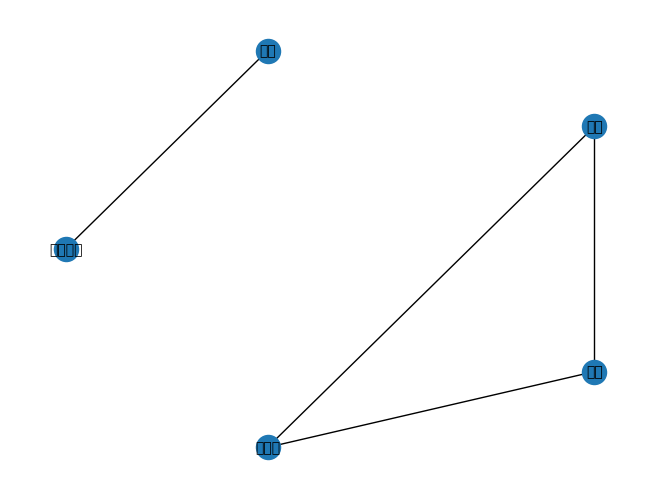

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
font_name = fm.FontProperties(fname="/content/drive/MyDrive/KOSSDA_텍스트마이닝_강의자료/강의자료/Day2/python_code/malgun.ttf").get_name()
rc('font', family=font_name)
# 맥의 경우, /Library/Fonts 또는 /System/Library/Fonts 에 있는 한글 폰트 사용

pos=nx.shell_layout(g)
nx.draw_shell(g)
nx.draw_networkx_labels(g,pos,font_family=font_name,font_size=10)
plt.show()

In [26]:
g['바나나']

AtlasView({'사과': {'weight': 2}, '주스': {'weight': 1}})

In [27]:
# graphml 파일로 저장하기
nx.write_graphml(g, 'Kr_test.graphml')

## 중심도 계산하기

In [28]:
# 디그리 중심도
sorted(nx.degree_centrality(g).items(), key=lambda x:x[1],reverse=True)

[('바나나', 0.5), ('사과', 0.5), ('주스', 0.5), ('대한민국', 0.25), ('축구', 0.25)]

In [29]:
# 매개 중심도
sorted(nx.betweenness_centrality(g).items(), key=lambda x:x[1],reverse=True)

[('대한민국', 0.0), ('바나나', 0.0), ('사과', 0.0), ('주스', 0.0), ('축구', 0.0)]

In [30]:
# 근접 중심도
sorted(nx.closeness_centrality(g).items(), key=lambda x:x[1],reverse=True)

[('바나나', 0.5), ('사과', 0.5), ('주스', 0.5), ('대한민국', 0.25), ('축구', 0.25)]